<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_R/blob/main/Colab_Notebook/02_07_05_03_survival_analysis_absolute_risk_regression_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![All-test](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 5.3 Absolute Risk Regression (Direct CIF Modeling)


Absolute Risk Regression** — also known as Direct CIF (Cumulative Incidence Function) Modeling— is a statistical approach used in competing risks survival analysis to model the absolute risk (probability)` of a specific event occurring by a certain time, directly.  Unlike traditional regression models that often focus on relative risks (how much more or less likely an event is in one group compared to another), absolute risk models aim to provide a direct estimate of the actual risk of an event.



## Overview


In competing risks survival data, an individual can experience `multiple types of events` — e.g., death from melanoma vs. death from other causes. The **Absolute Risk Regression (ARR)** model directly models the **Cumulative Incidence Function (CIF)** — that is, the absolute probability of a specific event by time `t`, given covariates. Unlike hazard models (Cox or Fine–Gray), ARR gives `direct probabilities`, which are easier to interpret in clinical and public health contexts. In competing risks, individuals may fail from one of several mutually exclusive causes (e.g., death from cancer vs. death from heart disease).


### What is Absolute Risk?


Imagine you're trying to predict the chance of someone developing a certain disease in the next 10 years.

`Relative Risk`: If Group A has a relative risk of 2 compared to Group B, it means people in Group A are twice as likely to develop the disease. However, if the baseline risk in Group B is very low (e.g., 1 in 10,000), then being "twice as likely" still means a very small absolute risk (2 in 10,000).

`Absolute Risk`: This is the actual probability. For example, "There is a 5% chance that this individual will develop the disease in the next 10 years." This is often more intuitive and directly relevant for patients and clinicians.



In contrast to the **Cox proportional hazards model**, which estimates *relative risk* (how much more likely one group is to experience an event compared to another), **absolute risk models estimate the actual risk (or hazard) on an absolute scale**, often expressed as:

- **Instantaneous event rate (hazard)** at time *t*, or  
- **Cumulative incidence**: the probability of experiencing the event by time *t*.

This makes them especially useful in **clinical decision-making**, **public health planning**, and **personalized risk prediction**, where knowing the *actual risk* (e.g., “You have a 15% chance of recurrence in 5 years”) is more actionable than a relative measure (e.g., “Your risk is 2× higher”).


In survival analysis with **competing risks**, absolute risk is quantified by the **Cumulative Incidence Function (CIF)** for event type \(k\):

$$
F_k(t) = P(T \leq t, \text{cause} = k)
$$

**Direct CIF modeling** regresses $F_k(t)$ directly on covariates $\mathbf{X}$, bypassing hazard modeling. A common approach uses **pseudo-values**:

1. Compute jackknife pseudo-values of the nonparametric CIF at fixed time points $t_1, \dots, t_K$:

$$
   \hat{\theta}_{i}(t) = n \hat{F}_k(t) - (n-1) \hat{F}_{k,-i}(t)
$$
   where $\hat{F}_{k,-i}(t)$ is the CIF leaving out subject $i$.

2. Regress pseudo-values on $\mathbf{X}$ using generalized estimating equations (GEE):

$$
   g\big( E[\hat{\theta}_{i}(t) \mid \mathbf{X}_i] \big) = \alpha(t) + \boldsymbol{\beta}(t)^\top \mathbf{X}_i
$$
   where $g(\cdot)$ is a link function (e.g., identity or logit).





### Advantages


- **Direct clinical interpretation**: “This treatment reduces absolute risk by 3% over 5 years.”
- **No proportional hazards assumption** (in time-varying versions).
- Better for **heterogeneous populations** where baseline risk varies widely.
- Naturally accommodates **time-varying effects**.


###  Challenges


- The hazard $\lambda(t \mid \mathbf{X})$ **must remain non-negative**—additive models can sometimes predict negative hazards if covariate effects are large (requires careful checking).
- Less familiar to many researchers compared to Cox models.
- Software implementation is less standardized (though `timereg`, `riskRegression`, and `cmprsk` in R support them).



## Setup R in Python Runtype - Install {rpy2}
{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp312-cp312-linux_x86_64.whl size=316573 sha256=b607a07db4f3e20d37dbdf67e32fc0080c67eb0bbab443ebd18a80038417bf2e
  Stored in directory: /root/.cache/pip/wheels/00/26/d5/d5e8c0b039915e785be870270e4a9263e5058168a03513d8cc
Successfully built rpy2


## Mount Google Drive

In [2]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Absolute Risk Regression in R


We’ll use the **`Melanoma`** dataset from the **`riskRegression`** package. This dataset contains survival data on patients with malignant melanoma, including competing risks of death from melanoma vs. other causes.


### Install Required R Packages


Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:


In [3]:
%%R
packages <-c(
		 'tidyverse',
		 'survival',
		 'survminer',
		 'ggsurvfit',
		 'tidycmprsk',
		 'ggfortify',
		 'timereg',
		 'cmprsk',
		 'condSURV',
		 'riskRegression',
		 'prodlim',
		 'lava',
		 'mstate',
		 'regplot',
		 'cmprskcoxmsm',
		 'timereg'
		 )


### Install missing packages

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')
devtools::install_github("ItziarI/WeDiBaDis", lib='drive/My Drive/R/')


### Verify installation

In [4]:
%%R
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method        from 
  nobs.multinom broom



     tidyverse       survival      survminer      ggsurvfit     tidycmprsk 
          TRUE           TRUE           TRUE           TRUE           TRUE 
     ggfortify        timereg         cmprsk       condSURV riskRegression 
          TRUE           TRUE           TRUE           TRUE           TRUE 
       prodlim           lava         mstate        regplot   cmprskcoxmsm 
          TRUE           TRUE           TRUE           TRUE           TRUE 
       timereg 
          TRUE 


### Load Packages

In [5]:
%%R
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))

In [6]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])

Successfully loaded packages:
 [1] "package:cmprskcoxmsm"   "package:regplot"        "package:mstate"        
 [4] "package:lava"           "package:prodlim"        "package:riskRegression"
 [7] "package:condSURV"       "package:cmprsk"         "package:timereg"       
[10] "package:ggfortify"      "package:tidycmprsk"     "package:ggsurvfit"     
[13] "package:survminer"      "package:ggpubr"         "package:survival"      
[16] "package:lubridate"      "package:forcats"        "package:stringr"       
[19] "package:dplyr"          "package:purrr"          "package:readr"         
[22] "package:tidyr"          "package:tibble"         "package:ggplot2"       
[25] "package:tidyverse"      "package:tools"          "package:stats"         
[28] "package:graphics"       "package:grDevices"      "package:utils"         
[31] "package:datasets"       "package:methods"        "package:base"          


### Data Preparation


n the period 1962-77, 205 patients with malignant melanoma (cancer of the skin) had a radical operation performed at Odense University Hospital, Denmark. All patients were followed until the end of 1977 by which time 134 were still alive while 71 had died (of out whom 57 had died from cancer and 14 from other causes).

`time`: time in days from operation

`status`: a numeric with values 0=censored 1=death.malignant.melanoma 2=death.other.causes

`event`: a factor with levels censored death.malignant.melanoma death.other.causes

`invasion`: a factor with levels level.0, level.1, level.2

`ici`: inflammatory cell infiltration (IFI): 0, 1, 2 or 3

`epicel`: a factor with levels not present present

`ulcer`: a factor with levels not present present

`thick`: tumour thickness (in 1/100 mm)

`sex`: a factor with levels Female Male

`age`: age at operation (years)

`logthick`: tumour thickness on log-scale




In [7]:
%%R
data(Melanoma, package = "riskRegression")
head(Melanoma)

  time status                    event invasion ici      epicel       ulcer
1   10      2       death.other.causes  level.1   2     present     present
2   30      2       death.other.causes  level.0   0 not present not present
3   35      0                 censored  level.1   2 not present not present
4   99      2       death.other.causes  level.0   2 not present not present
5  185      1 death.malignant.melanoma  level.2   2     present     present
6  204      1 death.malignant.melanoma  level.2   2 not present     present
  thick    sex age   logthick
1  6.76   Male  76  1.9110229
2  0.65   Male  56 -0.4307829
3  1.34   Male  41  0.2926696
4  2.90 Female  71  1.0647107
5 12.08   Male  52  2.4915512
6  4.84   Male  28  1.5769147


### Prepare Data and Event Definition

In [8]:
%%R
# Define event of interest: death from melanoma
Melanoma$event <- ifelse(Melanoma$status == 1, 1,
                  ifelse(Melanoma$status == 2, 2, 0))
Melanoma$event <- factor(Melanoma$event, levels = c(0,1,2),
                         labels = c("censored", "melanoma", "other"))

## Absolute Risk Regression  with `timereg`


The `timereg` package fits **semiparametric additive hazard models** for survival data, allowing covariate effects to be **time-varying** (Aalen model) or **constant** (Lin–Ying model). Unlike Cox regression, it models **absolute risk** (hazard differences), not relative risk, and does not require proportional hazards. Ideal for flexible, interpretable survival analysis with time-dependent effects.  

Install: `install.packages("timereg")`.




###  Fit Absolute Risk Model


Unlike Cox models (which model **relative risk**), **absolute risk models** directly model the **instantaneous risk (hazard)** as a sum of baseline hazard and covariate effects:

$$
\lambda(t | X) = \lambda_0(t) + \beta_1 X_1 + \beta_2 X_2 + \dots
$$


This model assumes the hazard is the sum of a time-varying baseline and linear covariate effects. comp.risk() from `timereg` fits such models for competing risks data.


In the **`timereg`** package, the `comp.risk()` function supports **several models** for **absolute risk (cumulative incidence) regression** in **competing risks**. These are specified via the `model =` argument.

By default, `model = "additive"` (logit-additive), but you can choose:

| Model | `model =` | Link Function | Interpretation |
|-------|-----------|---------------|----------------|
| **Additive (logit)** | `"additive"` | `logit(p) = α(t) + Xᵀβ(t)` | **Default**, most common |
| **Proportional** | `"prop"` | `p(t\|X) = 1 - [1 - p₀(t)]^{exp(Xᵀβ)}` | Proportional CIFs |
| **Relative cumulative incidence (rcif)** | `"rcif"` | `log(-log(1-p(t\|X))) = log(-log(1-p₀(t))) + Xᵀβ` | Fine-Gray–like on log-cum hazard scale |
| **Logistic** | `"logistic"` | `logit(p(t\|X)) = logit(p₀(t)) + Xᵀβ` | Proportional odds on CIF |



### `model = "additive"` — **Additive on Logit Scale (Default)**



$$
\text{logit}(P(T \leq t, D=1 \mid \mathbf{X})) = \text{logit}(P_0(t)) + \mathbf{X}^T \boldsymbol{\beta}(t)
$$
- **Baseline CIF**: $P_0(t)$ is the cumulative incidence at baseline.
- Covariates **additively shift the logit of CIF** over time.
- **Interpretation**: β(t) = change in log-odds of event by time t per unit increase in covariate.


In [9]:
%%R
# Fit absolute risk model
fit_abs <- comp.risk(
  Event(time, event) ~ const(age) + const(sex) + const(thick),
  data = Melanoma,
  cause = 1,                     # event of interest
  model = "additive",            # additive on logit scale
  n.sim = 1000,                  # for confidence bands
  resample.iid = 1
)

summary(fit_abs)

Competing risks Model 

Test for nonparametric terms 

Test for non-significant effects 
            Supremum-test of significance p-value H_0: B(t)=0
(Intercept)                          5.59                   0

Test for time invariant effects 
                  Kolmogorov-Smirnov test p-value H_0:constant effect
(Intercept)                         0.269                           0
                    Cramer von Mises test p-value H_0:constant effect
(Intercept)                          35.6                       0.002

Parametric terms : 
                   Coef.       SE Robust SE     z    P-val lower2.5% upper97.5%
const(age)      9.26e-07 7.93e-07  7.93e-07  1.17 2.43e-01 -6.28e-07   2.48e-06
const(sex)Male -4.10e-05 2.84e-05  2.84e-05 -1.44 1.50e-01 -9.67e-05   1.47e-05
const(thick)   -1.62e-05 2.97e-06  2.97e-06 -5.46 4.90e-08 -2.20e-05  -1.04e-05
   


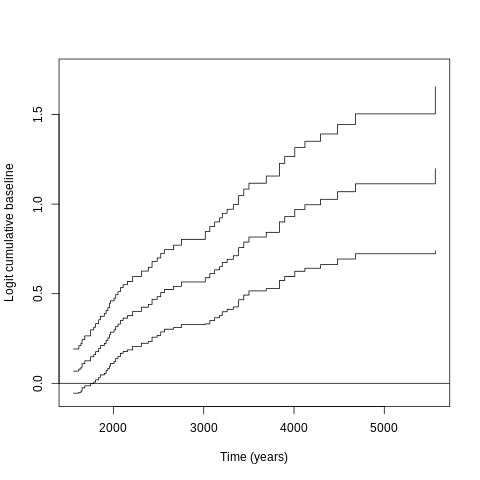

In [10]:
%%R
# Coefficient estimates (on logit scale)
fit_abs$gamma

# Standard errors
fit_abs$se.gamma

# Cumulative baseline (intercept function)
plot(fit_abs, score = 0, xlab = "Time (years)",
     ylab = "Logit cumulative baseline", main = "Baseline Logit Risk")

### `model = "prop"` — **Proportional Absolute Risk**



$$
P(T \leq t, D=1 \mid \mathbf{X}) = 1 - \left[1 - P_0(t)\right]^{\exp(\mathbf{X}^T \boldsymbol{\beta})}
$$

- **Baseline CIF**: $P_0(t)$ is the cumulative incidence at baseline.
- Covariates **scale the survival probability** from the event of interest.
- **Interpretation**: A positive β means **higher absolute risk** at all times.



In [11]:
%%R
fit_prop <- comp.risk(
  Event(time, event) ~ const(age) + const(sex),
  data = Melanoma,
  cause = 1,
  model = "prop",          # <-- proportional model
  n.sim = 1000
)

summary(fit_prop)

Competing risks Model 

Test for nonparametric terms 

Test for non-significant effects 
            Supremum-test of significance p-value H_0: B(t)=0
(Intercept)                          6.93                   0

Test for time invariant effects 
                  Kolmogorov-Smirnov test p-value H_0:constant effect
(Intercept)                          2.23                           0
                    Cramer von Mises test p-value H_0:constant effect
(Intercept)                          2530                           0

Parametric terms : 
                   Coef.      SE Robust SE      z P-val lower2.5% upper97.5%
const(age)      0.000604 0.00557   0.00557  0.108 0.914   -0.0103    0.01150
const(sex)Male -0.394000 0.20200   0.20200 -1.950 0.051   -0.7900    0.00191
   


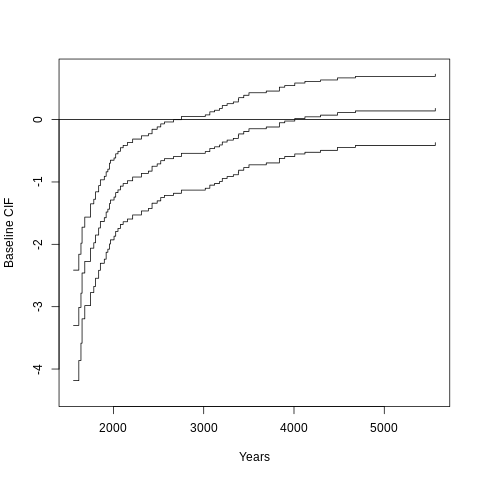

In [12]:
%%R
# Plot baseline CIF:
plot(fit_prop, score = 0, xlab = "Years", ylab = "Baseline CIF",
     main = "Proportional Model: Baseline Risk")


> **Use when**: You assume **proportionality of CIFs** (like proportional hazards, but for CIF).


###  `model = "rcif"` — **Relative Cumulative Incidence Function**



$$
\log\left(-\log(1 - F_1(t|\mathbf{X}))\right) = \log\left(-\log(1 - F_{10}(t))\right) + \mathbf{X}^T \boldsymbol{\beta}
$$

- Equivalent to **Fine-Gray model** on the **subdistribution hazard** scale.
- But here, **directly models CIF**.
- **Interpretation**: exp(β) = **subdistribution hazard ratio**.



In [13]:
%%R
fit_rcif <- comp.risk(
  Event(time, event) ~ const(age) + const(thick),
  data = Melanoma,
  cause = 1,
  model = "rcif",          # <-- Fine-Gray–like
  n.sim = 1000
)

summary(fit_rcif)

Competing risks Model 

Test for nonparametric terms 

Test for non-significant effects 
            Supremum-test of significance p-value H_0: B(t)=0
(Intercept)                          7.37                   0

Test for time invariant effects 
                  Kolmogorov-Smirnov test p-value H_0:constant effect
(Intercept)                          2.01                           0
                    Cramer von Mises test p-value H_0:constant effect
(Intercept)                          1320                           0

Parametric terms : 
                Coef.      SE Robust SE      z    P-val lower2.5% upper97.5%
const(age)    0.00177 0.00364   0.00364  0.488 6.26e-01  -0.00536     0.0089
const(thick) -0.17100 0.04080   0.04080 -4.190 2.77e-05  -0.25100    -0.0910
   



> **Note**: This is **very similar** to `cmprsk::crr()`, but allows **time-varying effects**.

> **Use when**: You want **Fine-Gray interpretation** but with **flexible time-varying effects**.


###  `model = "logistic"` — **Logistic (Proportional Odds on CIF)**



$$
\text{logit}(F_1(t|\mathbf{X})) = \text{logit}(F_{10}(t)) + \mathbf{X}^T \boldsymbol{\beta}
$$

- **Proportional odds** for the **cumulative incidence**.
- Covariates **shift the logit of CIF** by a constant.



In [14]:
%%R
fit_logistic <- comp.risk(
  Event(time, event) ~ const(sex) + const(thick),
  data = Melanoma,
  cause = 1,
  model = "logistic",      # <-- logistic model
  n.sim = 1000
)

summary(fit_logistic)

Competing risks Model 

Test for nonparametric terms 

Test for non-significant effects 
            Supremum-test of significance p-value H_0: B(t)=0
(Intercept)                          6.29                   0

Test for time invariant effects 
                  Kolmogorov-Smirnov test p-value H_0:constant effect
(Intercept)                           2.5                           0
                    Cramer von Mises test p-value H_0:constant effect
(Intercept)                          4230                           0

Parametric terms : 
                Coef.     SE Robust SE     z    P-val lower2.5% upper97.5%
const(sex)Male -0.250 0.2810    0.2810 -0.89 0.374000    -0.801      0.301
const(thick)   -0.274 0.0746    0.0746 -3.67 0.000241    -0.420     -0.128
   



> **Use when**: You want **proportional odds** assumption on the **absolute risk**.




###  Which Model to Choose?


| Model | `model =` | Assumption | Interpretation | Best For |
|------|-----------|-----------|----------------|----------|
| **Additive** | `"additive"` | Additive on logit scale | Flexible, no proportionality | **Prediction**, time-varying effects |
| **Proportional** | `"prop"` | CIFs are proportional | exp(β) = ratio of (1 - S) | Risk stratification |
| **RCIF** | `"rcif"` | Proportional subdistribution hazard | exp(β) = subdistribution HR | **Compare with Fine-Gray** |
| **Logistic** | `"logistic"` | Proportional odds on CIF | Odds ratio for cumulative risk | Clinical interpretation |



## Absolute Risk Regression with 'riskRegression` package


The `riskRegression` package provides functions for fitting various absolute risk regression models, including the **Additive Hazards Model** and **Cumulative Incidence Regression** for competing risks data. It allows for flexible modeling of absolute risk (CIF) directly, with options for time-varying effects and different link functions. This is a wrapper for the function `comp.risk` from the `timereg `package. The main difference is one marks variables in the formula that should have a time-dependent effect whereas in comp.risk one marks variables that should have a time constant (proportional) effect.

`ARR` function fits absolute risk regression models for competing risks data, directly modeling the cumulative incidence function (CIF) for a specific event type. It allows for flexible covariate effects and provides interpretable estimates of absolute risk.


### Absolute Risk Regression - single binary factor

In [15]:
%%R
# absolute risk regression - single binary factor
fit.arr <- ARR(Hist(time,status)~sex,data=Melanoma,cause=1)
print(fit.arr)

Competing risks regression model 

IPCW weights: marginal Kaplan-Meier for the censoring distribution.
Link: 'log' yielding absolute risk ratios
No covariates with time-varying coefficient specified.

Time constant regression coefficients:
 Variable Levels Coef Lower Upper  Pvalue
      sex   Male 1.87  1.17  3.01 0.00927


Note: The coefficients (Coef) are absolute risk ratios 


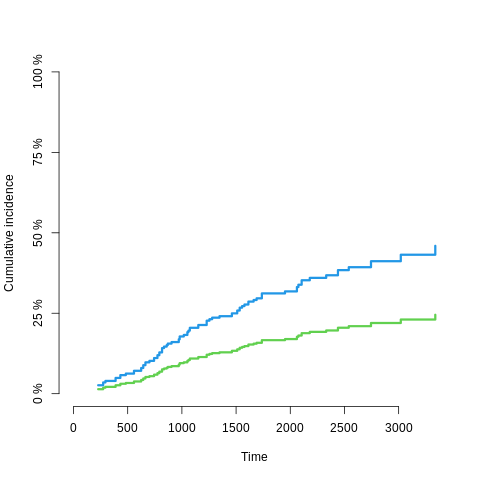

In [16]:
%%R
# show predicted cumulative incidences
plot(fit.arr,col=3:4,newdata=data.frame(sex=c("Female","Male")))


### Absolute Risk Regression - single continous variable

In [17]:
%%R
# Single continuous factor
## tumor thickness on the log-scale
Melanoma$logthick <- log(Melanoma$thick)

## absolute risk regression
fit2.arr <- ARR(Hist(time,status)~logthick,data=Melanoma,cause=1)
print(fit2.arr)

Competing risks regression model 

IPCW weights: marginal Kaplan-Meier for the censoring distribution.
Link: 'log' yielding absolute risk ratios
No covariates with time-varying coefficient specified.

Time constant regression coefficients:
 Variable Levels Coef Lower Upper Pvalue
 logthick        1.87  1.49  2.35 <1e-04


Note: The coefficients (Coef) are absolute risk ratios 


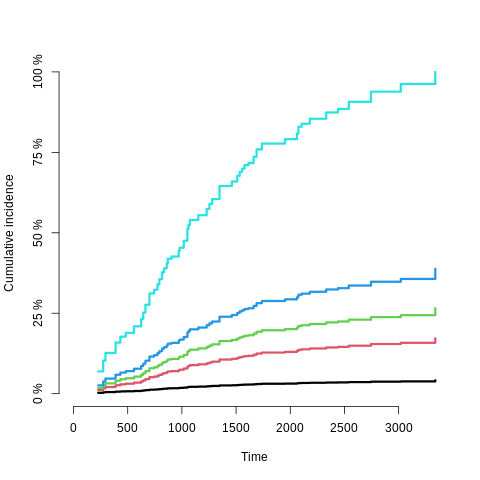

In [18]:
%%R
# show predicted cumulative incidences
plot(fit2.arr,col=1:5,newdata=data.frame(logthick=quantile(Melanoma$logthick)))

### Absolute Risk Regression - multiple covariates

In [19]:
%%R
# absolute risk model with multiple covariates
multi.arr <- ARR(Hist(time,status)~logthick+sex+age+ulcer,data=Melanoma,cause=1)
print(multi.arr)

Competing risks regression model 

IPCW weights: marginal Kaplan-Meier for the censoring distribution.
Link: 'log' yielding absolute risk ratios
No covariates with time-varying coefficient specified.

Time constant regression coefficients:
 Variable  Levels Coef Lower Upper  Pvalue
 logthick         1.56 1.156  2.10 0.00358
      sex    Male 1.28 0.809  2.03 0.28973
      age         1.00 0.986  1.01 0.99484
    ulcer present 2.48 1.349  4.57 0.00348


Note: The coefficients (Coef) are absolute risk ratios 


### Absolute risk regression - stratified model


Stratified model allow different baseline hazards for different levels of a factor variable.


In [20]:
%%R
# stratified model allowing different baseline risk for the two gender
multi.arr <- ARR(Hist(time,status)~thick+strata(sex)+age+ulcer,data=Melanoma,cause=1)
print(multi.arr)

Competing risks regression model 

IPCW weights: marginal Kaplan-Meier for the censoring distribution.
Link: 'log' yielding absolute risk ratios
Covariates with time-varying effects:

 sexMale (numeric)

Time constant regression coefficients:
 Variable  Levels Coef Lower Upper   Pvalue
    thick         1.08 1.026  1.13 0.002219
      age         1.00 0.986  1.02 0.956937
    ulcer present 3.08 1.733  5.49 0.000129


Note: The coefficients (Coef) are absolute risk ratios 


### Logistic Absolute Risk Regression


`LRR` function fits logistic absolute risk regression models for competing risks data, directly modeling the cumulative incidence function (CIF) for a specific event type using a logistic link. It provides interpretable estimates of absolute risk in terms of odds ratios.


In [21]:
%%R
# logistic absolute risk regression
fit.lrr <- LRR(Hist(time,status)~thick,data=Melanoma,cause=1)
summary(fit.lrr)


riskRegression: Competing risks regression model 

IPCW estimation. The weights are based on
the Kaplan-Meier estimate for the censoring distribution.

Link function: 'logistic' yielding odds ratios, see help(riskRegression).

Covariates with time-varying effects:

 Intercept (numeric)

The effects of these variables depend on time.The column 'Intercept' is the baseline risk where all the covariates have value zero

     (Intercept)
230  "1.007"    
770  "1.050"    
1100 "1.098"    
1700 "1.158"    
3300 "1.347"    

Shown are selected time points, use

plot.riskRegression

to investigate the full shape.


Covariates with time-constant effects:

 thick (numeric)

Time constant regression coefficients:

 Factor   Coef exp(Coef) StandardError      z         CI_95  Pvalue
  thick 0.1942    1.2143        0.0477 4.0690 [1.106;1.333] < 1e-04


Note: The values exp(Coef) are odds ratios 


## Summary and Conclusion


**Absolute Risk Regression** (Direct CIF Modeling) directly estimates the **probability of event occurrence** by a given time under competing risks.
It’s especially valuable for **clinical decision-making**, **risk communication**, and **prediction**, where absolute probabilities (not just relative hazards) matter.


## Resources


* Gerds, T. A., & Andersen, P. K. (2012). *Absolute risk regression for competing risks: interpretation, link functions, and prediction.* **Statistics in Medicine**, 31(29), 3921–3930.
* `riskRegression` package documentation (CRAN): [https://cran.r-project.org/package=riskRegression](https://cran.r-project.org/package=riskRegression)

- Martinussen, T., & Scheike, T. H. (2006). *Dynamic Regression Models for Survival Data*. Springer.
- `timereg` package vignette: `vignette("timereg")`
- `riskRegression` package documentation